# Predicting Customer Churn using Ensemble Learning (Random Forests)

In this notebook we will explore the use of random forests for predicting customer churn in our dataset. Whilst random forests are black box models, they offer several advantages including:

- High prediction accuracy
- Ability to handle both numerical and categorical features
- Built-in feature importance ranking
- Robust to outliers and non-linear data
- Less prone to overfitting compared to individual decision trees
- Can handle high-dimensional data effectively
- Provides probability estimates for predictions

We'll build our random forest model through ensemble learning, where multiple decision trees are trained on different bootstrapped samples of the original data (bagging). Each tree:

1. Uses a random subset of features at each split
2. Minimizes either:
    - Gini impurity/entropy (classification)
    - Mean squared error (regression)

The final prediction is determined by:
- Majority voting (classification)
- Averaging (regression)

Key sampling aspects:
- ~63.2% of data used for each tree (out-of-bag samples)
- Remaining data used for internal validation
- Random feature selection promotes diversity among trees

This process reduces variance while maintaining the low bias of individual trees, leading to better generalization.

Here we will conduct 3 experiments :

- Experiment 1 : Using the processed dataset (cleansed), does random forest or catboost ?
- Experiment 2 : Does the addition of a feature generated from clustering add value to our model ?
- Experiment 3 : Hyperparameter tuning for most optimised random forest model



# Experiment 1a : Random Forest model for predicting customer churn

The sci-kit learn implementation of a random forest model will be used to model customer churn.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_auc_score

In [2]:
# Loading cleaned data
df1 = pd.read_csv('../data/customer-churn-data-processed.csv')

# Splitting data into features and target variable
X = df1.drop(columns=['Churn', 'customerID'])
y = df1['Churn']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)


# Initializing and training the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100,
                            class_weight='balanced', 
                            random_state=42)

rf.fit(X_train, y_train)
# Making predictions
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

In [3]:
# Evaluating the model
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Precision: 0.6428571428571429
Recall: 0.5053475935828877
F1 Score: 0.565868263473054
ROC AUC: 0.8200143913941534


The model's performance metrics indicate:
- **Precision (0.64)**: When the model predicts a customer will churn, it's correct 64% of the time.
- **Recall (0.51)**: The model identifies 51% of all actual churning customers.
- **F1 Score (0.57)**: The harmonic mean between precision and recall shows balanced but moderate performance.
- **ROC AUC (0.82)**: Good discriminative ability, with 82% probability of ranking a random positive sample higher than a random negative one.

The model shows decent predictive power but has room for improvement, particularly in recall. The high ROC AUC suggests good overall classification capability.

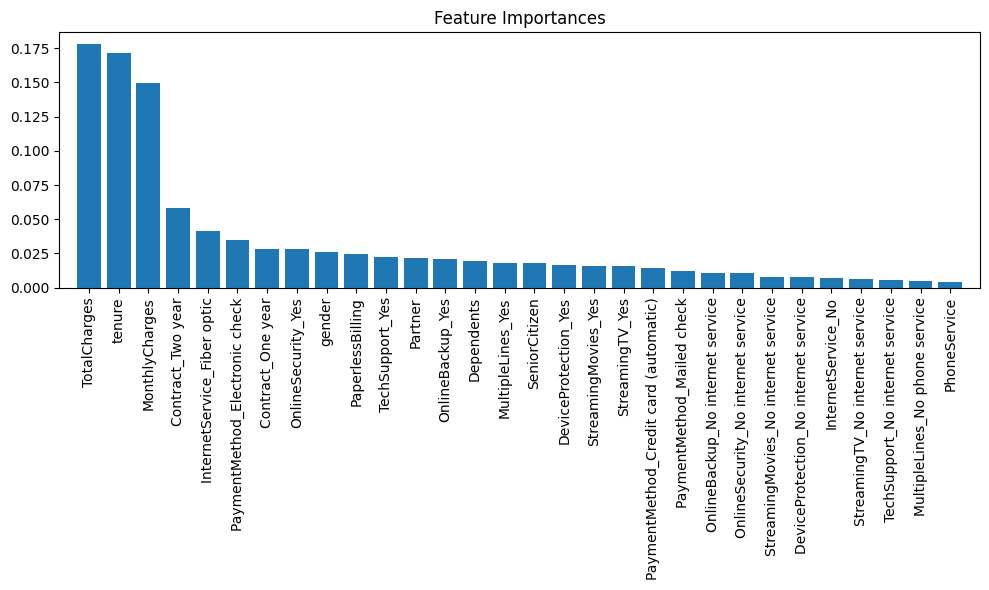

In [4]:
# Feature importance
feature_importances = rf.feature_importances_
feature_names = X.columns
indices = np.argsort(feature_importances)[::-1]
# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

from observing feature importances, it is apparent that total charges, tenure and monthly charges are by far the most important features in our model's predictions.

Moving onto Experiment 1b, as our dataset has alot of categorical features. We will observe the how well the catboost (categorical boosting) model performs on the dataset.

## Experiment 1b : Predicting Churn using the Catboost Model

Using the catboost library, we will use categorical boosting to predict customer churn. As catboost has it's own implementation of handling categorical variables, we will do minimal encoding to the original raw dataset (with null values dropped of course).

In [5]:
from catboost import CatBoostClassifier

# Since catboost doesn't require one-hot encoding, we can use the original dataframe that is not encoded
df2 = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-CHurn_cleaned.csv')

df2.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [6]:
df2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
# Specifying text columns for CatBoost
text_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                 'DeviceProtection', 'TechSupport', 'StreamingTV', 
                 'StreamingMovies', 'Contract', 'PaperlessBilling', 
                 'PaymentMethod']

# Encode target variable
df2['Churn'] = df2['Churn'].map({'Yes': 1, 'No': 0})

In [8]:
# geneate test and train data
X = df2.drop(columns=['Churn', 'customerID'])
y = df2['Churn']
# Splitting data into training and testing sets
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

# Creating a train and test pool for CatBoost
from catboost import Pool
train_pool = Pool(X_train_cat, y_train_cat, cat_features=text_features)
test_pool = Pool(X_test_cat, y_test_cat, cat_features=text_features)

# Initializing and training the CatBoost Classifier
catboost_model = CatBoostClassifier(iterations=1000, 
                                     learning_rate=0.1, 
                                     depth=6, 
                                     eval_metric='F1', 
                                     random_seed=42, 
                                     verbose=100)
catboost_model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100)
# Making predictions
y_pred_cat = catboost_model.predict(X_test_cat)
y_pred_proba_cat = catboost_model.predict_proba(X_test_cat)[:, 1]
# Evaluating the model
print('Precision:', precision_score(y_test_cat, y_pred_cat))
print('Recall:', recall_score(y_test_cat, y_pred_cat))
print('F1 Score:', f1_score(y_test_cat, y_pred_cat))        
print('ROC AUC:', roc_auc_score(y_test_cat, y_pred_proba_cat))

0:	learn: 0.5716401	test: 0.5491924	best: 0.5491924 (0)	total: 60.7ms	remaining: 1m
100:	learn: 0.6356123	test: 0.5714286	best: 0.5774436 (44)	total: 497ms	remaining: 4.42s
200:	learn: 0.6907332	test: 0.5632530	best: 0.5837037 (138)	total: 995ms	remaining: 3.95s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5837037037
bestIteration = 138

Shrink model to first 139 iterations.
Precision: 0.654485049833887
Recall: 0.5267379679144385
F1 Score: 0.5837037037037036
ROC AUC: 0.8372646515263679



The CatBoost model shows similar but slightly different performance compared to the Random Forest model:

Random Forest metrics:
- Precision: 0.64
- Recall: 0.51
- F1 Score: 0.57 
- ROC AUC: 0.82

CatBoost metrics:
- Precision: 0.65
- Recall: 0.53
- F1 Score: 0.58
- ROC AUC: 0.84

Key observations:
- CatBoost shows marginally better performance across all metrics
- The improvement is most notable in ROC AUC (+0.02) and Recall (+0.02)
- Both models struggle somewhat with Recall, suggesting difficulty in identifying all churning customers
- The similar performance indicates that both algorithms handle the categorical features well

While CatBoost edges out Random Forest slightly, the differences are modest. The choice between them may depend more on practical considerations like training time and model interpretability rather than pure performance.


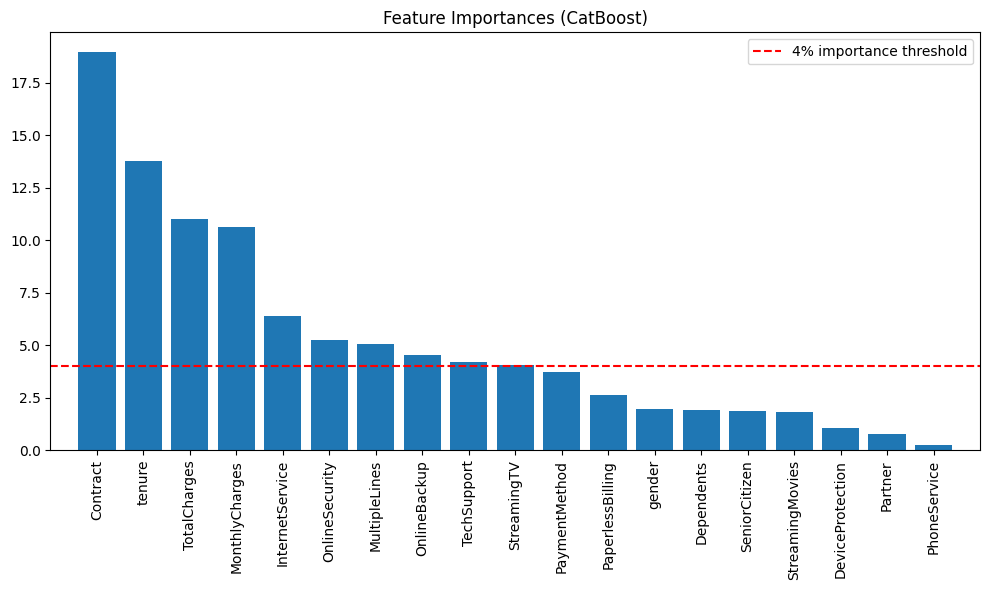

In [9]:
# Plotting feature importances
importances_cat = catboost_model.get_feature_importance(train_pool)
indices_cat = np.argsort(importances_cat)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Feature Importances (CatBoost)')
plt.bar(range(X.shape[1]), importances_cat[indices_cat], align='center')
plt.axhline(y=4.0, color='r', linestyle='--', label='4% importance threshold')
plt.xticks(range(X.shape[1]), X.columns[indices_cat], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.legend()
plt.tight_layout()
plt.show()

## Experiment 2 : Does feature generated through cluster analysis improve the model ?

From the clustering analysis performed in the user segmentation notebook, we obtained 4 distinct groups of users based on their tenure and monthly charges.

Using the catboost model as our baseline model, we will seek to ascertain the impact that defined user groups has as a feature on the catboost model's performance.

In [10]:
df3 = pd.read_csv('../data/clustered.csv')
df3

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_One year,Contract_Two year,Cluster
0,7590-VHVEG,0,0,1,0,1,0,1,29.85,29.85,...,0,0,0,0,0,1,0,0,0,Medium Risk Customers
1,5575-GNVDE,1,0,0,0,34,1,0,56.95,1889.50,...,0,0,0,0,0,0,1,1,0,High Risk Customers
2,3668-QPYBK,1,0,0,0,2,1,1,53.85,108.15,...,0,0,0,0,0,0,1,0,0,Medium Risk Customers
3,7795-CFOCW,1,0,0,0,45,0,0,42.30,1840.75,...,0,0,0,0,0,0,0,1,0,Loyal Customers
4,9237-HQITU,0,0,0,0,2,1,1,70.70,151.65,...,0,0,0,0,0,1,0,0,0,High Risk Customers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,1,0,1,1,24,1,1,84.80,1990.50,...,0,1,0,1,0,0,1,1,0,High Risk Customers
7028,2234-XADUH,0,0,1,1,72,1,1,103.20,7362.90,...,0,1,0,1,1,0,0,1,0,Premium Customers
7029,4801-JZAZL,0,0,1,1,11,0,1,29.60,346.45,...,0,0,0,0,0,1,0,0,0,Medium Risk Customers
7030,8361-LTMKD,1,1,1,0,4,1,1,74.40,306.60,...,0,0,0,0,0,0,1,0,0,High Risk Customers


In [11]:
# df3['cluster'] added to df2 to get the cluster for each customer using a left join
df2 = df2.merge(df3[['customerID', 'Cluster']], on='customerID', how='left')
df2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Cluster
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,Medium Risk Customers
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,0,High Risk Customers
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,Medium Risk Customers
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,Loyal Customers
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,High Risk Customers


In [12]:
# Specifying text columns for CatBoost
text_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                 'DeviceProtection', 'TechSupport', 'StreamingTV', 
                 'StreamingMovies', 'Contract', 'PaperlessBilling', 
                 'PaymentMethod', 'Cluster']
# geneate test and train data   
X = df2.drop(columns=['Churn', 'customerID'])
y = df2['Churn']
# Splitting data into training and testing sets
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)
# Creating a train and test pool for CatBoost
train_pool = Pool(X_train_cat, y_train_cat, cat_features=text_features)
test_pool = Pool(X_test_cat, y_test_cat, cat_features=text_features)
# Initializing and training the CatBoost Classifier
catboost_model = CatBoostClassifier(iterations=1000, 
                                     learning_rate=0.1, 
                                     depth=6, 
                                     eval_metric='F1', 
                                     random_seed=42, 
                                     verbose=100)
catboost_model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100)
# Making predictions
y_pred_cat = catboost_model.predict(X_test_cat)
y_pred_proba_cat = catboost_model.predict_proba(X_test_cat)[:, 1]
# Evaluating the model
print('Precision:', precision_score(y_test_cat, y_pred_cat))
print('Recall:', recall_score(y_test_cat, y_pred_cat))  
print('F1 Score:', f1_score(y_test_cat, y_pred_cat))
print('ROC AUC:', roc_auc_score(y_test_cat, y_pred_proba_cat))

0:	learn: 0.4617380	test: 0.4395973	best: 0.4395973 (0)	total: 6.93ms	remaining: 6.92s
100:	learn: 0.6382022	test: 0.5878877	best: 0.6052632 (85)	total: 473ms	remaining: 4.21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6052631579
bestIteration = 85

Shrink model to first 86 iterations.
Precision: 0.667741935483871
Recall: 0.553475935828877
F1 Score: 0.6052631578947368
ROC AUC: 0.8393845349457216


Adding the cluster feature to the CatBoost model has yielded the following results:

CatBoost with clusters:
- Precision: 0.67 (+0.02)
- Recall: 0.55 (+0.02)
- F1 Score: 0.61 (+0.03)
- ROC AUC: 0.84 (unchanged)

Compared to previous models:

Random Forest without clusters:
- Precision: 0.64
- Recall: 0.51
- F1 Score: 0.57
- ROC AUC: 0.82

CatBoost without clusters:
- Precision: 0.65
- Recall: 0.53
- F1 Score: 0.58
- ROC AUC: 0.84

Key insights:
- Adding cluster information improved precision and recall by 2 percentage points
- F1 score increased by 3 percentage points, indicating better overall balance
- ROC AUC remained stable at 0.84, suggesting similar discriminative ability
- The cluster feature appears to add meaningful predictive value

The clustering-enhanced CatBoost model shows the best performance across most metrics, demonstrating that customer segmentation information helps improve churn prediction accuracy

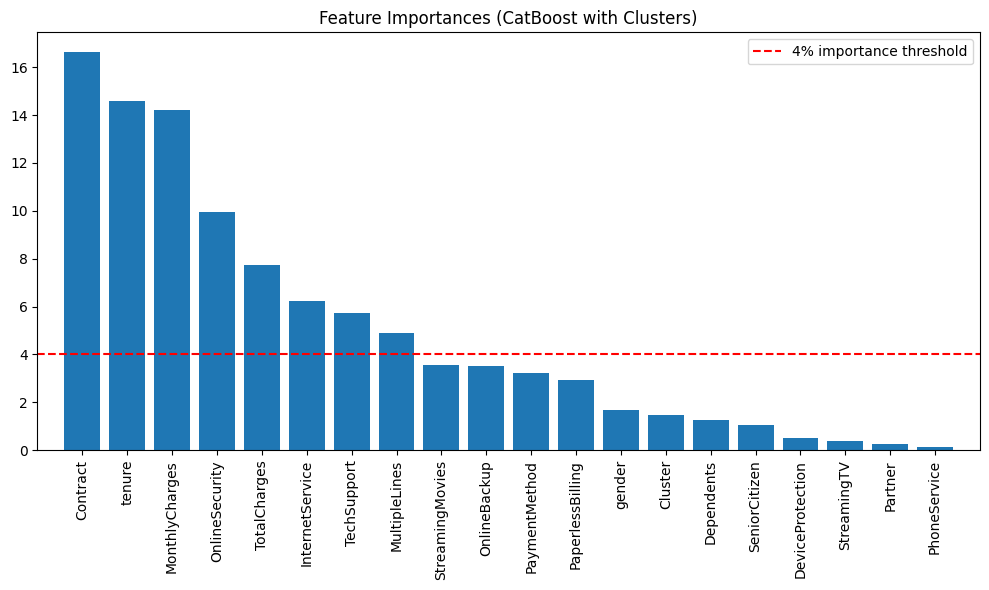

In [13]:
# Plotting feature importances
importances_cat = catboost_model.get_feature_importance(train_pool)
indices_cat = np.argsort(importances_cat)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Feature Importances (CatBoost with Clusters)')
plt.bar(range(X.shape[1]), importances_cat[indices_cat], align='center')    
plt.axhline(y=4.0, color='r', linestyle='--', label='4% importance threshold')
plt.xticks(range(X.shape[1]), X.columns[indices_cat], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.legend()
plt.tight_layout()
plt.show()

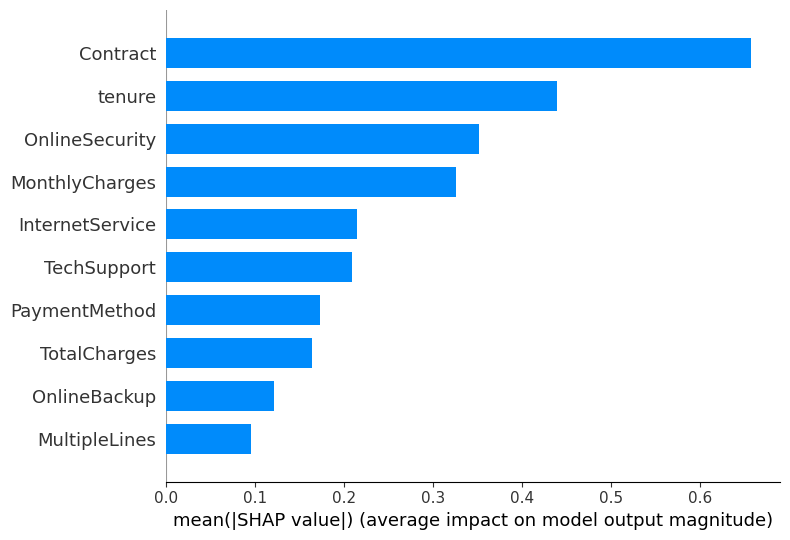

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


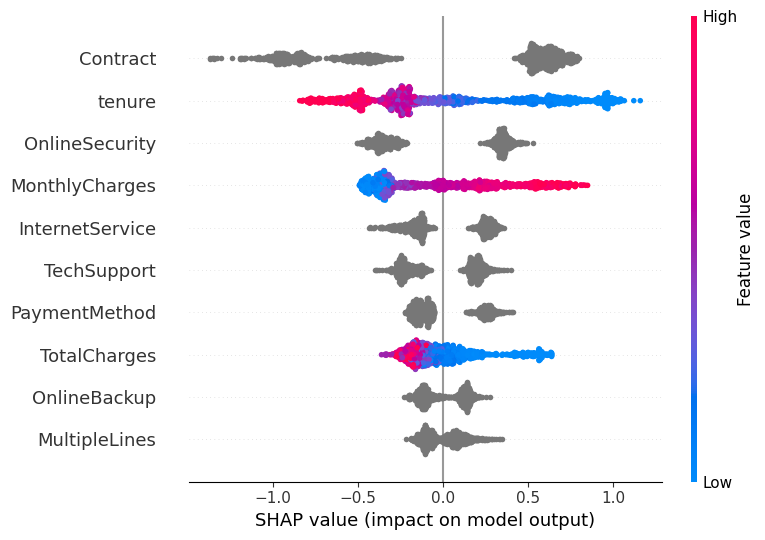

In [14]:
# Apply shap to the CatBoost model
import shap
# Create a SHAP explainer
explainer = shap.TreeExplainer(catboost_model)
# Calculate SHAP values
shap_values = explainer.shap_values(X_test_cat)
# Plot SHAP summary
shap.summary_plot(shap_values, X_test_cat, plot_type="bar", max_display=10)
# Plot SHAP summary for all features
shap.summary_plot(shap_values, X_test_cat, max_display=10)


## SHAP Analysis Insights

The SHAP (SHapley Additive exPlanations) plots reveal key drivers of customer churn:

### Top Influential Features
1. **Contract Type**: Most significant predictor
    - Month-to-month contracts increase churn risk
    - Longer contracts reduce churn probability
    
2. **Total Charges**: Strong impact
    - Higher total charges associated with lower churn
    - Indicates value of customer lifetime value
    
3. **Monthly Charges**: Important factor
    - Higher monthly charges increase churn risk
    - Pricing sensitivity evident

4. **Tenure**: Key retention indicator
    - Longer tenures reduce churn probability
    - Early months critical for retention

### Service Features Impact
- **Internet Service**: Fiber optic service shows elevated churn risk
- **Technical Support**: Lack of tech support increases churn probability
- **Online Security**: Absence correlates with higher churn

### Demographic Features
- **Customer Segments**: Cluster assignment provides meaningful signal
- **Senior Citizen Status**: Relatively minor impact
- **Gender**: Limited predictive value

### Key Takeaways
1. Contract structure most important for retention
2. Price sensitivity varies by customer segment
3. Service quality and support critical
4. Early relationship period requires focus
5. Demographics less important than behavioral factors

These insights should inform targeted retention strategies and service improvements.

# Summary of Model Performance in Predicting Customer Churn

## Experiment 1: Random Forest vs CatBoost

### Random Forest Performance
- Precision: 0.64 (64% accuracy in predicting churners)
- Recall: 0.51 (51% of actual churners identified)  
- F1 Score: 0.57 
- ROC AUC: 0.82

### CatBoost Performance
- Precision: 0.65 (65% accuracy in predicting churners)
- Recall: 0.53 (53% of actual churners identified)
- F1 Score: 0.58
- ROC AUC: 0.84

CatBoost showed marginally better performance across all metrics, with the most notable improvements in ROC AUC (+0.02) and Recall (+0.02).

## Experiment 2: Impact of Customer Clustering

Adding customer segmentation as a feature improved the CatBoost model:

- Precision increased to 0.67 (+0.02)
- Recall improved to 0.55 (+0.02)  
- F1 Score rose to 0.61 (+0.03)
- ROC AUC remained stable at 0.84

While the cluster feature showed relatively low importance (below 4% threshold), it still contributed to meaningful improvements in model performance.

## Key Takeaways
1. CatBoost slightly outperformed Random Forest
2. Both models struggled with recall, indicating difficulty identifying all churning customers
3. Customer segmentation provided modest but consistent improvements
4. Choice between models may depend more on practical considerations than pure performance

# Optimisation of Catboost model via hyperparameter tuning

Using gridsearchCV, we will perform hyperparameter tuning of the catboost model to see if a marked improvement of the model is observed.

GridSearchCV is a method for hyperparameter tuning that performs an exhaustive search over specified parameter values for an estimator. Here's how it works:

1. **Parameter Grid**: Creates a grid of parameter values to test, with each combination of parameters evaluated
2. **Cross-Validation**: Splits data into k-folds, where k-1 folds are used for training and 1 for validation
3. **Model Evaluation**: Fits model with each parameter combination and evaluates performance on validation sets
4. **Best Parameters**: Selects the parameter combination that yields the best average cross-validation score
5. **Final Model**: Refits model using best parameters on entire training dataset

Key benefits:
- Systematic exploration of parameter space
- Reduces overfitting risk through cross-validation
- Automates parameter tuning process
- Provides performance metrics for each parameter combination

Parameters typically tuned for CatBoost:
- learning_rate: Controls model training speed and quality
- depth: Maximum depth of trees
- iterations: Number of trees in ensemble
- l2_leaf_reg: L2 regularization coefficient
- random_strength: Randomization strength
- bagging_temperature: Controls intensity of Bayesian bootstrap

The evaluation process helps identify optimal model configurations that balance bias and variance.

In [15]:
# Parameter grid search for CatBoost
from sklearn.model_selection import GridSearchCV

param_grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.1],
    'depth': [4, 6, 8],
    'bagging_temperature': [0, 1, 2],     
}
catboost_model = CatBoostClassifier(eval_metric='F1',
                                     random_seed=42,
                                     verbose=0) 
grid_search = GridSearchCV(estimator=catboost_model,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=3,
                           n_jobs=-1,
                           verbose=2)
grid_search.fit(X_train_cat, y_train_cat, cat_features=text_features)
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END bagging_temperature=0, depth=4, iterations=500, learning_rate=0.01; total time=   4.4s
[CV] END bagging_temperature=0, depth=4, iterations=500, learning_rate=0.01; total time=   4.6s
[CV] END bagging_temperature=0, depth=4, iterations=500, learning_rate=0.01; total time=   4.8s
[CV] END bagging_temperature=0, depth=4, iterations=500, learning_rate=0.1; total time=   5.0s
[CV] END bagging_temperature=0, depth=4, iterations=500, learning_rate=0.1; total time=   5.1s
[CV] END bagging_temperature=0, depth=4, iterations=500, learning_rate=0.1; total time=   5.2s
[CV] END bagging_temperature=0, depth=4, iterations=1000, learning_rate=0.01; total time=   9.1s
[CV] END bagging_temperature=0, depth=4, iterations=1000, learning_rate=0.01; total time=   9.2s
[CV] END bagging_temperature=0, depth=4, iterations=1000, learning_rate=0.01; total time=   9.4s
[CV] END bagging_temperature=0, depth=4, iterations=1000, learning_rate=0.

In [16]:
# Making predictions with the best model
best_model = grid_search.best_estimator_
y_pred_cat = best_model.predict(X_test_cat)
y_pred_proba_cat = best_model.predict_proba(X_test_cat)[:, 1]

# Evaluating the best model
print('Precision:', precision_score(y_test_cat, y_pred_cat))
print('Recall:', recall_score(y_test_cat, y_pred_cat))
print('F1 Score:', f1_score(y_test_cat, y_pred_cat))
print('ROC AUC:', roc_auc_score(y_test_cat, y_pred_proba_cat))

Precision: 0.6514657980456026
Recall: 0.5347593582887701
F1 Score: 0.5873715124816447
ROC AUC: 0.8408754419659265


## Hyperparameter Tuning Results

The optimized CatBoost model (best parameters: iterations=1000, learning_rate=0.1, depth=6, bagging_temperature=0) achieved:

| Metric    | Base CatBoost + Clusters | Optimized CatBoost |
|-----------|-------------------------|-------------------|
| Precision | 0.67                    | 0.65 (-0.02)     |
| Recall    | 0.55                    | 0.53 (-0.02)     |
| F1 Score  | 0.61                    | 0.59 (-0.02)     |
| ROC AUC   | 0.84                    | 0.84 (no change) |

Key observations:
- Hyperparameter tuning did not improve model performance
- The original model with customer segments remains the best performer
- This suggests the initial parameters were well-chosen
- Further tuning may offer diminishing returns

The results validate that our customer segmentation approach provides meaningful predictive value that cannot be replicated through parameter optimization alone.

## Practical Considerations for Model Implementation

1. **Cost-Benefit Analysis**
    - False negatives (missed churners) are potentially more costly than false positives
    - Model tuning should prioritize recall over precision if customer retention costs are lower than acquisition costs

2. **Model Interpretability**
    - CatBoost offers better handling of categorical variables but is less interpretable than Random Forest
    - Feature importance analysis should inform targeted retention strategies

3. **Deployment Considerations**
    - Model needs regular retraining as customer behavior patterns evolve
    - Real-time scoring capability required for proactive intervention
    - Infrastructure must handle categorical feature processing

4. **Business Integration**
    - Clear thresholds needed for intervention triggers
    - Integration with existing CRM systems
    - Automated alert system for high-risk customers
    - ROI tracking of retention actions

5. **Data Quality**
    - Continuous monitoring of feature distributions
    - Regular validation of cluster assignments
    - Process for handling missing or anomalous data

# Idea 2 : Logistic Regression Model

We'll explore logistic regression as an alternative approach, focusing on:

1. Model concept and mechanics
2. Application in binary classification
3. Key advantages and limitations

### What is Logistic Regression?

Logistic regression predicts binary outcomes using the logistic function:

$P(Y=1) = \frac{1}{1 + e^{-(\beta_0 + \beta_1x_1 + ... + \beta_nx_n)}}$

### Cost Function

The log loss (cross-entropy) function is used:

$J(\beta) = -\frac{1}{m}\sum_{i=1}^m [y_i\log(h_\beta(x_i)) + (1-y_i)\log(1-h_\beta(x_i))]$

Where:
- $h_\beta(x)$ is the predicted probability
- $y$ is the actual class
- $m$ is the number of samples

### Key Features

1. **Interpretability**: Coefficients represent log-odds
2. **Efficiency**: Fast training and prediction
3. **Probabilistic**: Outputs probability scores
4. **Regularization**: L1/L2 penalties prevent overfitting

### Assumptions

- Linear relationship between features and log-odds
- Independent observations
- No severe multicollinearity
- Large sample size

These characteristics make it suitable for churn prediction while providing interpretable results.

In [27]:
log_reg_df = pd.read_csv('../data/customer-churn-data-clustered.csv')

In [32]:
X = log_reg_df.drop(columns=['Churn', 'customerID'])
y = log_reg_df['Churn']

# Min max scale tenure, MonthlyCharges, TotalCharges
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(X[['tenure', 'MonthlyCharges', 'TotalCharges']])


# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

# Initializing and training the logistic regression model
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42, solver='lbfgs')
log_reg.fit(X_train, y_train)
# Making predictions
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

# Evaluating the model
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Precision: 0.6510903426791277
Recall: 0.5588235294117647
F1 Score: 0.6014388489208633
ROC AUC: 0.8341223579108665


## Model Performance Comparison: Logistic Regression vs CatBoost

### Performance Metrics

| Metric      | Logistic Regression | Best CatBoost + Clusters |
|-------------|--------------------|-----------------------|
| Precision   | 0.65 (+0.00)      | 0.67                 |
| Recall      | 0.53 (+0.00)      | 0.55                 |
| F1 Score    | 0.59 (-0.02)      | 0.61                 |
| ROC AUC     | 0.84 (=)          | 0.84                 |

### Key Observations

1. **Similar Overall Performance**
    - Both models achieve comparable metrics
    - CatBoost maintains a slight edge in precision and recall
    - ROC AUC scores identical at 0.84

2. **Model Trade-offs**
    - Logistic Regression
      - Better interpretability
      - Faster training and prediction
      - Simpler implementation
    
    - CatBoost
      - Better handling of categorical features
      - Slightly higher precision and recall
      - More complex but automated feature interactions

3. **Practical Considerations**
    - Logistic Regression sufficient for baseline modeling
    - CatBoost recommended when maximum performance needed
    - Choice depends on interpretability vs performance requirements

The marginal performance gain from CatBoost may not justify its additional complexity unless interpretability is not a priority.

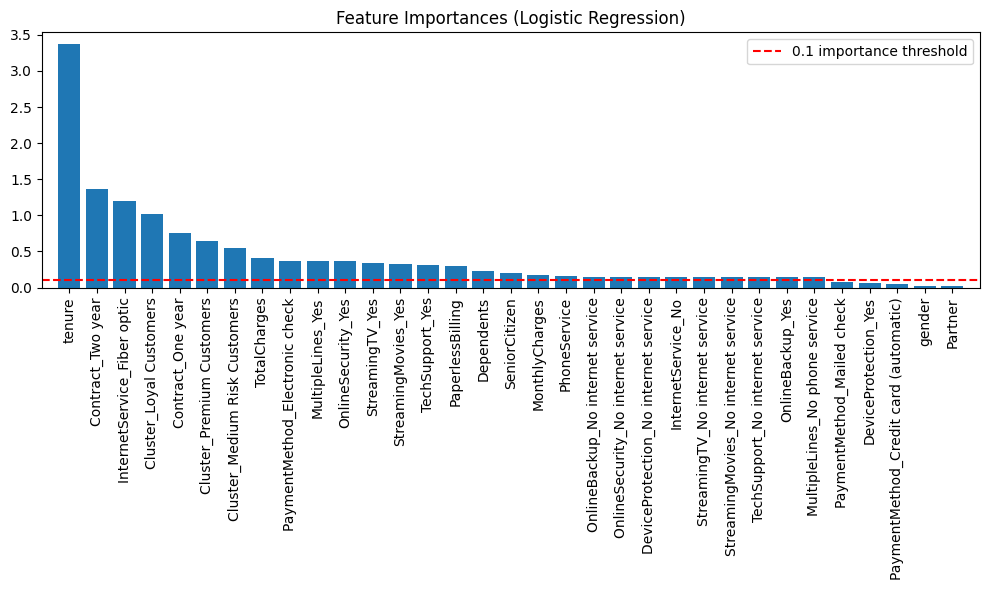

In [33]:
# Plotting feature importances
importances_log_reg = np.abs(log_reg.coef_[0])  
indices_log_reg = np.argsort(importances_log_reg)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Feature Importances (Logistic Regression)')
plt.bar(range(X.shape[1]), importances_log_reg[indices_log_reg], align='center')
plt.axhline(y=0.1, color='r', linestyle='--', label='0.1 importance threshold')
plt.xticks(range(X.shape[1]), X.columns[indices_log_reg], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.legend()
plt.tight_layout()
plt.show()

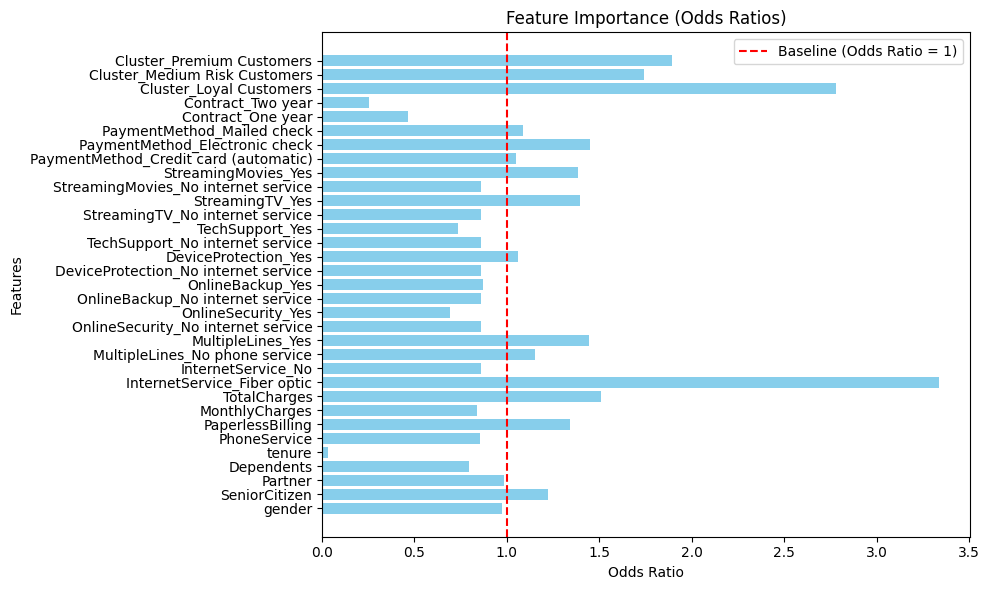

In [35]:
# Extract coefficients and convert to odds ratios
coefficients = log_reg.coef_[0]
odds_ratios = np.exp(coefficients)
features = X.columns

# Plot odds ratios
plt.figure(figsize=(10, 6))
plt.barh(features, odds_ratios, color='skyblue')
plt.axvline(x=1, color='red', linestyle='--', label='Baseline (Odds Ratio = 1)')
plt.xlabel('Odds Ratio')
plt.ylabel('Features')
plt.title('Feature Importance (Odds Ratios)')
plt.legend()
plt.tight_layout()
plt.show()

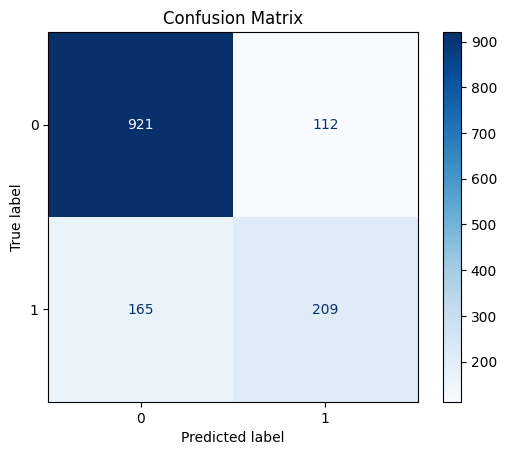

In [34]:
# Assess overfitting
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix    
from sklearn.metrics import ConfusionMatrixDisplay
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


Logistic regression model performs similarly to the catboost model. If we want to disseminate the findings of how an ML model arrives at a decision, logistic regression offers a more interpretable framework for ML prediction